**File handaling**<br>
Install all the libraries needed for the code

In [ ]:
!pip install uproot awkward lz4 xxhash
!pip install iminuit
!pip install probfit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.4/328.4 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.2/583.2 KB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.0/351.0 KB 21.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: iminuit
    Found existing installation

In [ ]:
import uproot
f=uproot.open ("/content/drive/MyDrive/B2HHH_MagnetDown.root")
f.keys()

['DecayTree;1']

In [ ]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt


In [ ]:
tree=f["DecayTree"].arrays(library="np")

**Defining classes and useful functions**<br>
In this cell, I defined a class and some functions to avoid repetitions in the code, in particular
<ul>
<li> The class Daughter, which creates a daughter particle given the tree and the number (1,2, or 3), retrieving information about its momentum on the three components, the probabilities of being a kaon or a pion, calculating its total momentum. In addition, it has also a method to calculate the total energy of the particle. Although this may be an unusual approach, in my opinion, it simplifies the readability of the code and the accessibility of the information 
<li> A function to create three daughter particles given the tree
<li> A function to calculate the total momentum of the mother and a function to calculate its mass
<li> A function to plot the fitting of the model
<li> A function to calculate the asymmetry and one for its uncertainty


</ul>


In [ ]:
#defining useful classes and functions
class Daughter:
  def __init__(self, tree, number):
    self.PX=tree["H{}_PX".format(number)]
    self.PY=tree["H{}_PY".format(number)]
    self.PZ=tree["H{}_PZ".format(number)]
    self.PTOT=sqrt(square(self.PX)+square(self.PY)+square(self.PZ))#total momentum of the daughter particle
    self.ProbK=tree["H{}_ProbK".format(number)]
    self.ProbPi=tree["H{}_ProbPi".format(number)]
    
  def getTotalEnergy(self, mass):
    return  sqrt(square(self.PTOT)+mass**2)#total energy of the particle

def getDaughterParticles(tree):
  daughters=[]
  for i in range(1,4):
    daughters.append(Daughter(tree,i))
  return daughters


def totalMomentumMother(H1,H2,H3):
  return sqrt(square(H1.PX+H2.PX+H3.PX)+square(H1.PY+H2.PY+H3.PY)+square(H1.PZ+H2.PZ+H3.PZ))

def massMother(H1,H2,H3,mass):
  return sqrt(square(H1.getTotalEnergy(mass)+H2.getTotalEnergy(mass)+H3.getTotalEnergy(mass))-square(totalMomentumMother(H1,H2,H3)))

def getModel(data,pdf,params):
  binned_likelihood = probfit.BinnedChi2(pdf, data,bound=(min(data),max(data)))
  minuit = iminuit.Minuit(binned_likelihood, **params)
  result=minuit.migrad()
  ((data_edges, datay), (errorp, errorm), (total_pdf_x, total_pdf_y), parts)=binned_likelihood.draw(minuit,parts=True);
  plt.figure(figsize=(30, 9))
  plt.errorbar(probfit.mid(data_edges), datay, errorp, fmt='ko', capsize=1, color='g', label='Data')
  plt.plot(total_pdf_x, total_pdf_y, color='blue', lw=2, label='Total Model')
  colors = ['orange', 'purple', 'DarkGreen']
  labels = ['Background', 'Signal 1', 'Signal 2']
  for color, label, part in zip(colors, labels, parts):
    x, y = part
    plt.plot(x, y, ls='--', color=color, label=label)
    plt.grid(True)
    plt.legend(loc='upper left')
  print(result.params)
  return result.params

def asymmetry(Nplus, Nminus):
  return (Nminus-Nplus)/(Nminus+Nplus)

def deviation(Nplus, Nminus):
  return sqrt((1-asymmetry(Nplus, Nminus)**2)/(Nminus+Nplus))






In [ ]:
#creating the istances for the three daughter particles
H1,H2,H3=getDaughterParticles(tree)


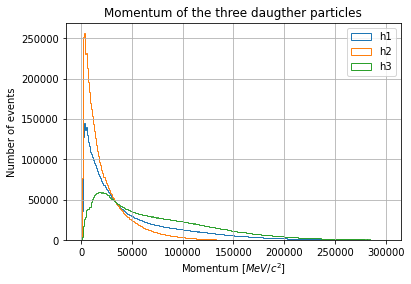

In [ ]:
#plotting the hystogram
plt.hist(H1.PTOT,300,(0,300000),histtype='step',label='h1');
plt.hist(H2.PTOT,300,(0,300000),histtype='step',label='h2'); 
plt.hist(H3.PTOT,300,(0,300000),histtype='step',label='h3');  #the semicolon avoid printing the all array

plt.legend(loc='upper right');
plt.title("Momentum of the three daugther particles");
plt.xlabel('Momentum [$MeV/c^2$]');
plt.ylabel('Number of events');
plt.grid();

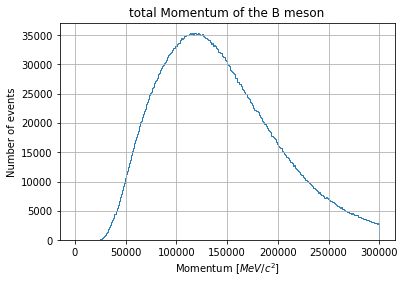

In [ ]:
#Calculating the total momentum of the mother 
mother_ptot=totalMomentumMother(H1,H2,H3)


plt.hist(mother_ptot,300,(0,300000),histtype='step');

plt.title("total Momentum of the B meson");
plt.xlabel('Momentum [$MeV/c^2$]');
plt.ylabel('Number of events');
plt.grid();

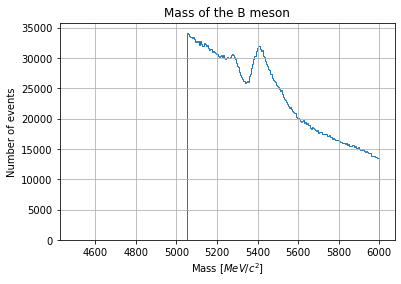

In [ ]:
#total mass of the mother
massK=493.677
mass_mother=massMother(H1,H2,H3,massK)

plt.hist(mass_mother,300,(4500,6000),histtype='step');

plt.title("Mass of the B meson");
plt.xlabel('Mass [$MeV/c^2$]');
plt.ylabel('Number of events');
plt.grid();

#Does this match what we would expect from theory?

According to Wikipedia (https://en.wikipedia.org/wiki/B_meson), the mass for B meson is $5279.34\  MeV/c^2$. The histogram has three peaks: 
<ul>
<li> The highest around $5000\  MeV/c^2$
<li> A second one between $5200\  MeV/c^2$ and $5400\  MeV/c^2$ (which correspond to the theoretical mass of B mesons)
<li> A third one around $5400\  MeV/c^2$
</ul>
Considering that no filter has been applied yet and, therefore, there are also data about particles that are not B meson, the results seem reasonable.

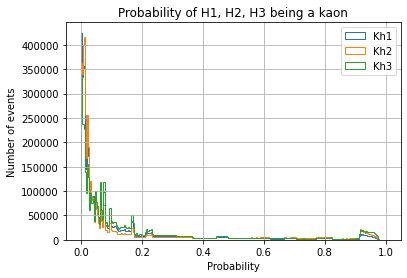

In [ ]:
#Make plots of H1/H2/H3 _ProbK on one plot
plt.hist(H1.ProbK,300,(0,1),histtype='step',label='Kh1');
plt.hist(H2.ProbK,300,(0,1),histtype='step',label='Kh2');
plt.hist(H3.ProbK,300,(0,1),histtype='step',label='Kh3');
plt.title("Probability of H1, H2, H3 being a kaon");
plt.xlabel('Probability');
plt.ylabel('Number of events');
plt.legend(loc='upper right');
plt.grid();

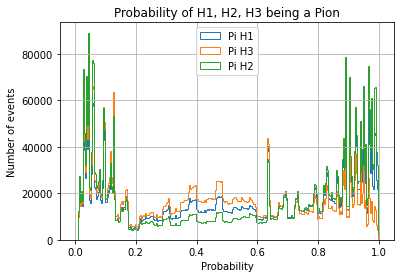

In [ ]:
#Make plots of H1/H2/H3 _ProbPi on one plot
plt.hist(H1.ProbPi,300,(0,1),histtype='step',label='Pi H1');
plt.hist(H3.ProbPi,300,(0,1),histtype='step',label='Pi H3');
plt.hist(H2.ProbPi,300,(0,1),histtype='step',label='Pi H2');
plt.legend(loc='upper center');
plt.title("Probability of H1, H2, H3 being a Pion");
plt.xlabel('Probability');
plt.ylabel('Number of events');
plt.grid();


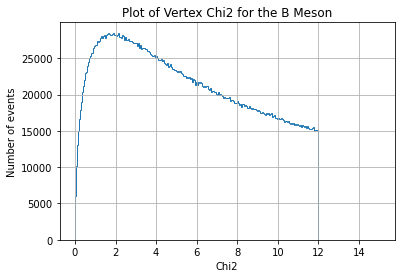

In [ ]:
#make a plot of the B_VertexChi2
plt.hist(tree["B_VertexChi2"],300,(0,15),histtype='step',label='B vertex ki');

plt.xlabel('Chi2');
plt.ylabel('Number of events');
plt.title("Plot of Vertex Chi2 for the B Meson");
plt.grid();

Based on the previous plots, it was decided to keep the data relative to those particles whose probability to be a Kion is more than 50%, that are not muon and whose probability to be a pion is less tha 0.15%

In [ ]:
#Making the selction
selection="(H1_ProbK>0.5) & (H2_ProbK>0.5) & (H3_ProbK>0.5) & (H1_ProbPi<0.15) & (H1_isMuon==0) & (H2_isMuon==0) &(H3_isMuon==0)& (H2_ProbPi<0.15) & (H3_ProbPi<0.15)"
cutTree=f["DecayTree"].arrays(library="np",cut=selection)



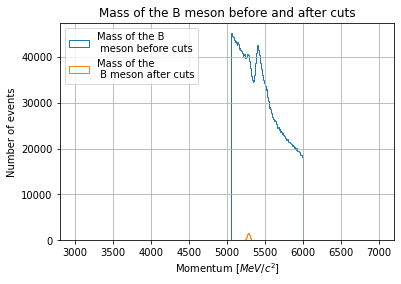

In [ ]:
H1_cut,H2_cut,H3_cut=getDaughterParticles(cutTree)


mass_mother_cut=massMother(H1_cut,H2_cut,H3_cut,massK)

plt.hist(mass_mother,300,(4000,6000),histtype='step',label="Mass of the B \n meson before cuts");
plt.hist(mass_mother_cut,300,(3000,7000),histtype='step',label="Mass of the \n B meson after cuts");
plt.legend(loc='upper left');
plt.title("Mass of the B meson before and after cuts");
plt.xlabel('Momentum [$MeV/c^2$]');
plt.ylabel('Number of events');
plt.grid();


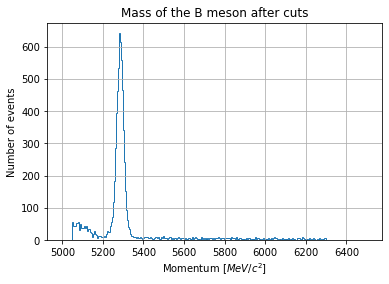

In [ ]:
#mother cut alone

plt.hist(mass_mother_cut,300,(5000,6500),histtype='step');
plt.title("Mass of the B meson after cuts");
plt.xlabel('Momentum [$MeV/c^2$]');
plt.ylabel('Number of events');
plt.grid()

#What do you notice about your histogram now?


The histogram is now way narrower, with the peak between $5200\  MeV/c^2$ and $5400\  MeV/c^2$ (which correspond to the mass of the B mesons). However, the number of events is greatly reduced. 

In [ ]:
import iminuit
import probfit

<ipython-input-22-f0eefb298efd>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pdf=probfit.AddPdf(signal,background)
<ipython-input-22-f0eefb298efd>:13: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  getModel(pdf=pdf,data=data,params=dict(mean=mean(data),sd=std(data),lam=0.02 , NSig= data.shape[0]/30,NBack= data.shape[0]/30))


┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │ 5.2841e3  │ 0.0000e3  │            │            │         │         │       │
│ 1 │ sd    │ 1.8735e1  │ 0.0000e1  │            │            │         │         │       │
│ 2 │ NSig  │ 5.4413e3  │ 0.0000e3  │            │            │         │         │       │
│ 3 │ lam   │ 9.639e281 │ 0.000e281 │            │            │         │         │       │
│ 4 │ NBack │  2.062e2  │  0.000e2  │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


"\nbinned_likelihood = probfit.BinnedChi2(pdf, data,bound=(min(data),max(data)))\nminuit = iminuit.Minuit(binned_likelihood, mean=mean(data),sd=std(data),lam=0.02)\n\nminuit.migrad()\nbinned_likelihood.draw(minuit,parts=True);\nbinned_likelihood.show(minuit, parts=False);\n\nFind a way to plot decentely the separate parts because they are all there (checked with Sanne's code)\nNot sure if addpdf is working\n"

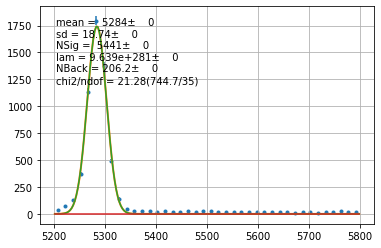

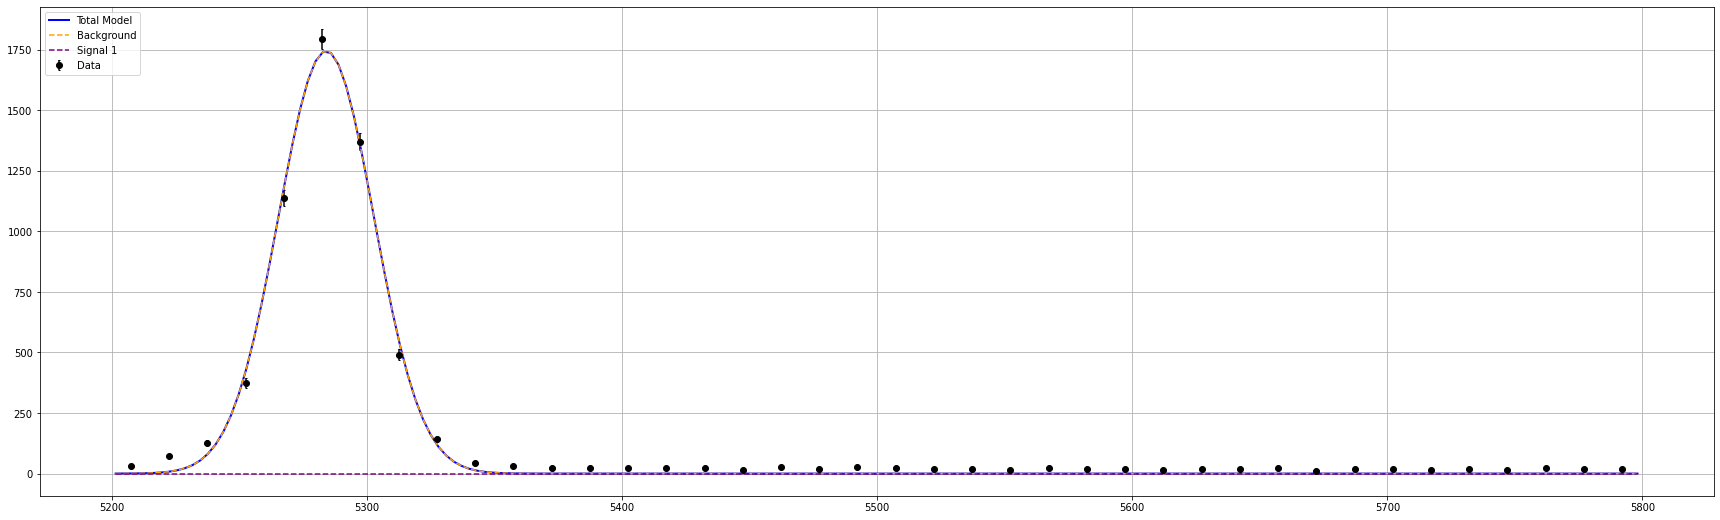

In [ ]:
data=array([m for m in mass_mother_cut if (m>5200) and (m<5800)])
def exponential(x,lam):
  return exp(-lam*x)

def gaussian(x,mean, sd):
  return probfit.pdf.gaussian(x,mean=mean,sigma=sd)

signal=probfit.Extended(gaussian, extname='NSig')
background=probfit.Extended(exponential, extname='NBack')

pdf=probfit.AddPdf(signal,background)

getModel(pdf=pdf,data=data,params=dict(mean=mean(data),sd=std(data),lam=0.02 , NSig= data.shape[0]/30,NBack= data.shape[0]/30))



'''
binned_likelihood = probfit.BinnedChi2(pdf, data,bound=(min(data),max(data)))
minuit = iminuit.Minuit(binned_likelihood, mean=mean(data),sd=std(data),lam=0.02)

minuit.migrad()
binned_likelihood.draw(minuit,parts=True);
binned_likelihood.show(minuit, parts=False);

Find a way to plot decentely the separate parts because they are all there (checked with Sanne's code)
Not sure if addpdf is working
'''
    


In [ ]:
print(probfit.describe(probfit.AddPdf(signal,background)))

['x', 'mean', 'sd', 'NSig', 'lam', 'NBack']


<ipython-input-27-d0d8bbd6d6c8>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(probfit.describe(probfit.AddPdf(signal,background)))


**Counting**

In [ ]:
totalCharge= "H1_Charge+H2_Charge+H3_Charge"
#filtering by charge
B_minus=f["DecayTree"].arrays(cut="({}==-1)&{}".format(totalCharge,selection), library="pd")#with numpy gives some errors
B_plus=f["DecayTree"].arrays(cut="({}==1)&{}".format(totalCharge,selection), library="pd")


<ipython-input-24-0ee790c8dc65>:7: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  N_minus=getModel(pdf=pdf,data=data_B_minus,params=dict(mean=mean(data_B_minus),sd=std(data_B_minus),lam=0.02))[0]["value"]
<ipython-input-21-631f51aac267>:29: InitialParamWarning: Parameter NSig does not have neither initial value nor limits.
  minuit = iminuit.Minuit(binned_likelihood, **params)
<ipython-input-21-631f51aac267>:29: InitialParamWarning: Parameter NBack does not have neither initial value nor limits.
  minuit = iminuit.Minuit(binned_likelihood, **params)
<ipython-input-22-f0eefb298efd>:3: RuntimeWarning: overflow encountered in exp
  return exp(-lam*x)


┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │ 5.2849e3  │ 0.0000e3  │            │            │         │         │       │
│ 1 │ sd    │ 1.8857e1  │ 0.0000e1  │            │            │         │         │       │
│ 2 │ NSig  │ 2.5416e3  │ 0.0000e3  │            │            │         │         │       │
│ 3 │ lam   │   2e-2    │   0e-2    │            │            │         │         │       │
│ 4 │ NBack │     0     │     0     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


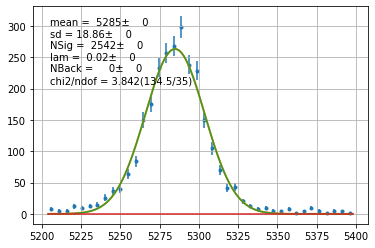

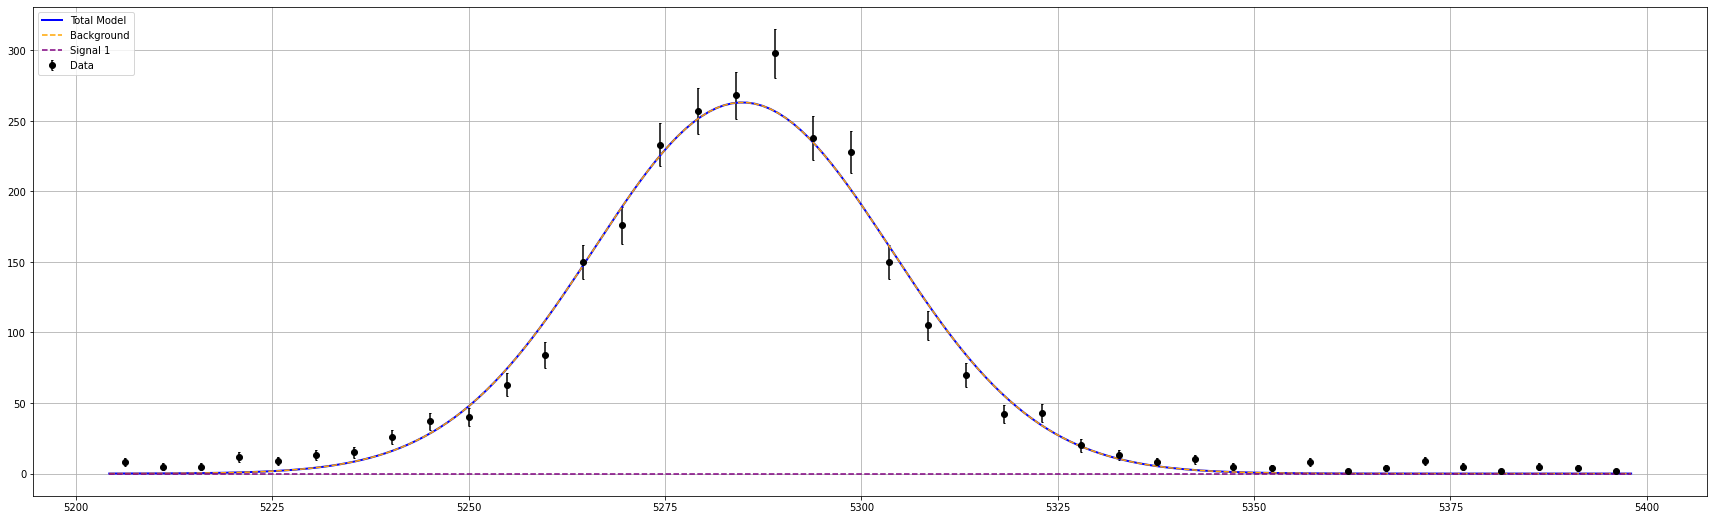

In [ ]:
#Model B_minus
H1_Bminus,H2_Bminus,H3_Bminus=getDaughterParticles(B_minus)
mass_mother_Bminus=massMother(H1_Bminus,H2_Bminus,H3_Bminus,massK)

data_B_minus=array([m for m in mass_mother_Bminus if (m>5200) and (m<5400)])

N_minus=getModel(pdf=pdf,data=data_B_minus,params=dict(mean=mean(data_B_minus),sd=std(data_B_minus),lam=0.02))[0]["value"]



<ipython-input-25-7161b1baaba6>:7: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  N_plus=getModel(pdf=pdf,data=data_B_plus,params=dict(mean=mean(data_B_plus),sd=std(data_B_plus),lam=0.02))[0]["value"]
<ipython-input-21-631f51aac267>:29: InitialParamWarning: Parameter NSig does not have neither initial value nor limits.
  minuit = iminuit.Minuit(binned_likelihood, **params)
<ipython-input-21-631f51aac267>:29: InitialParamWarning: Parameter NBack does not have neither initial value nor limits.
  minuit = iminuit.Minuit(binned_likelihood, **params)
<ipython-input-22-f0eefb298efd>:3: RuntimeWarning: overflow encountered in exp
  return exp(-lam*x)


┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │ 5.2832e3  │ 0.0000e3  │            │            │         │         │       │
│ 1 │ sd    │ 1.8039e1  │ 0.0000e1  │            │            │         │         │       │
│ 2 │ NSig  │  2.852e3  │  0.000e3  │            │            │         │         │       │
│ 3 │ lam   │   2e-2    │   0e-2    │            │            │         │         │       │
│ 4 │ NBack │     0     │     0     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


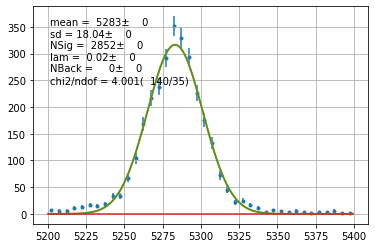

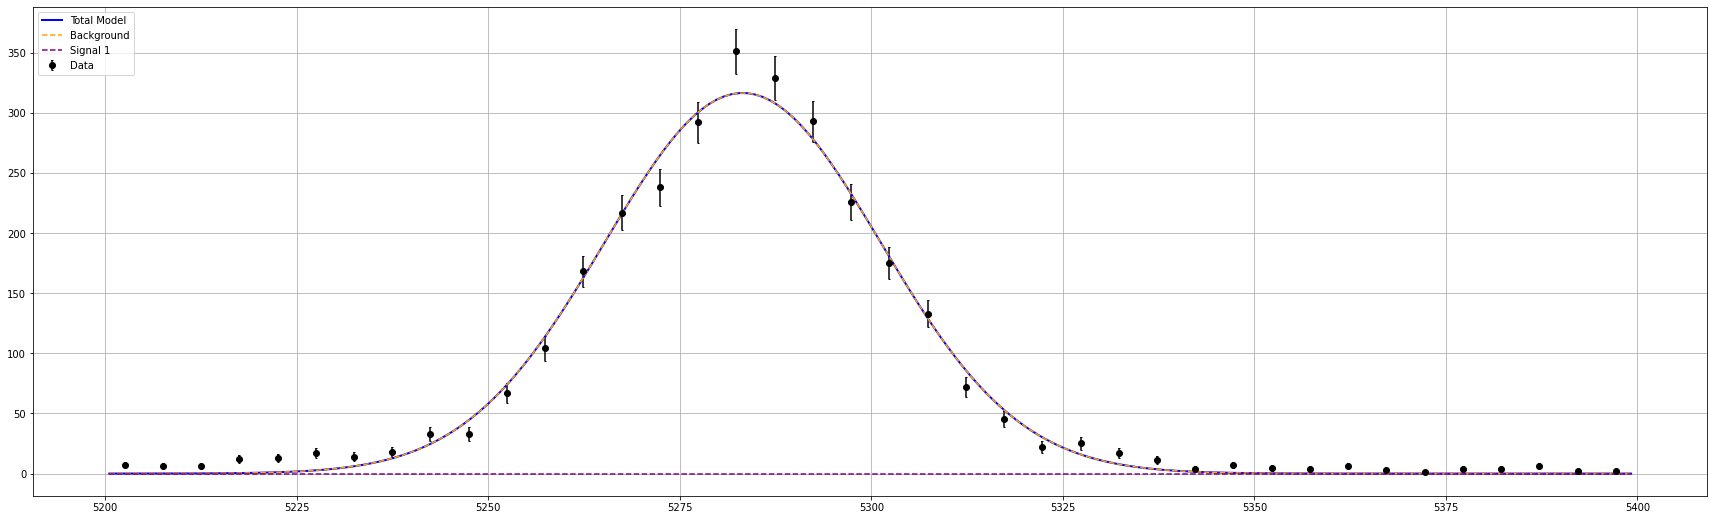

In [ ]:
#Model B_plus
H1_Bplus,H2_Bplus,H3_Bplus=getDaughterParticles(B_plus)
mass_mother_Bplus=massMother(H1_Bplus,H2_Bplus,H3_Bplus,massK)

data_B_plus=array([m for m in mass_mother_Bplus if (m>5200) and (m<5400)])

N_plus=getModel(pdf=pdf,data=data_B_plus,params=dict(mean=mean(data_B_plus),sd=std(data_B_plus),lam=0.02))[0]["value"]


In [ ]:
#calculating the asimmetry
print("The deviation is:", deviation(N_minus,N_plus))
print("The Asymmetry is:", asymmetry(N_minus,N_plus))

The deviation is: 0.0097275222818702
The Asymmetry is: -0.00015662931882315227


The results shows indeed an asimmetry between the B+ meson and B-. This asymettry of the matter over anti-matter is why we (and the entire universe) exist. 